In [2]:
import os.path
import types
import math
import yaml
import phacsl.utils.formats.csv_tools as csv_tools
import phacsl.utils.formats.yaml_tools as yaml_tools

%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats, optimize

def loadCSVByAbbrev(modelDir, fname, key=None):
    if key is None:
        key = 'abbrev'
    fullName = os.path.join(modelDir, fname)
    with open(fullName) as fl:
        keys, recs = csv_tools.parseCSV(fl)
    assert key in keys, ('%s has no "%s" field' % (fullName, key))
    return {rec[key]: rec for rec in recs}

def typeCheck(val):
    return (type(val) in [types.FloatType, types.IntType]) 

modelDir = '/home/welling/git/pyrhea/models/ChicagoLand'

allKeySet, recs = yaml_tools.parse_all(os.path.join(modelDir, 'facilityfacts'))
facDict = {r['abbrev']:r for r in recs}

kL, uRecs = yaml_tools.parse_all(os.path.join(modelDir, 'facilityfactsUpdated'))
updatedFacDict= {r['abbrev']:r for r in uRecs}


In [3]:
isSNForVSNF = [k for k, rec in facDict.items() if rec['category'] in ['SNF', 'VSNF']]


In [4]:
def getVal(abbrev, key):
    if key == 'totalTransfersOut':
        if key in facDict[abbrev]:
            return sum([d['count']['value'] for d in facDict[abbrev][key]])
        else:
            return None
    else:
        if key in facDict[abbrev]:
            return float(facDict[abbrev][key]['value'])
        else:
            return None

def checkPairValid(val, prov):
    for s in ['average', 'median', 'regression', 'slope']:
        if s in prov.lower():
            return False
    if val == 0:
        return False
    return True
    
def checkValid(abbrev, key):
    if key == 'totalTransfersOut':
        for hook in facDict[abbrev][key]:
            if not checkPairValid(hook['value'], hook['prov']):
                return False
        return True
    else:
        hook = facDict[abbrev][key]
        return checkPairValid(hook['value'], hook['prov'])


In [5]:
def findThoseWith(key):
    if key == 'totalTransfersOut':
        return [k for k in isSNForVSNF if key in facDict[k]]
    else:
        return [k for k in isSNForVSNF if key in facDict[k] and typeCheck(facDict[k][key]['value'])]


In [6]:
def findThoseWithout(key):
    l = findThoseWith(key)
    return [k for k in isSNForVSNF if k not in l]

In [7]:
def findThoseWithoutValid(key):
    noneL = findThoseWithout(key)
    withL = findThoseWith(key)
    fakeL = [k for k in withL if not checkValid(k, key)]
    return noneL + fakeL


In [8]:
def findThoseWithValid(key):
    withL = findThoseWith(key)
    validL = [k for k in withL if checkValid(k, key)]
    return validL


In [17]:

print len(isSNForVSNF)

363


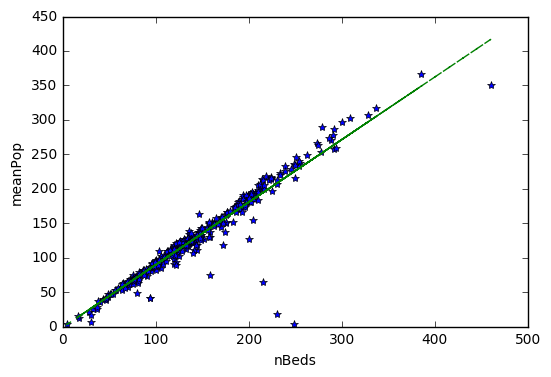

slope: 0.908189012909
intercept: -1.03383666603
std_err: 0.0178734280511
r_value: 0.944229978962
p_value: 1.57105127932e-153
----------------------
ADAM_119_S, 48.916559,
BEVE_1703_S, 86.152309,
BROO_3506_S, 137.919082,
CHIC_6685_S, 131.561759,
COMM_503_S, 100.683333,
CONS_1000_S, 61.631205,
DECA_353_S, 63.447583,
EXTE_8633_S, 88.876876,
FAL_9630_S, 33.477346,
GEOR_3623_S, 62.539394,
HANC_101_S, 47.100181,
HANC_203_S, 167.889320,
HEAR_3100_S, 107.948845,
HEND_1700_S, 77.978607,
HEND_1900_S, 158.807430,
HEND_251_S, 76.162229,
HEND_3175_S, 167.889320,
HEND_8800_S, 147.909161,
JOHN_2901_S, 98.866955,
JOHN_5909_S, 58.906638,
KIND_2300_S, 147.909161,
KIND_3415_S, 77.070418,
KIND_8400_S, 69.804906,
LIFE_1000_S, 66.172150,
MAJO_10352_S, 83.427742,
MAJO_2350_S, 162.440186,
MAJO_3301_S, 135.194515,
MAJO_4410_S, 124.296247,
MAJO_5025_S, 105.224278,
MAJO_601_S, 145.184594,
MAJO_7935_S, 203.308691,
MAJO_8380_S, 89.785065,
MCAL_18300_S, 87.968687,
MICH_802_S, 107.948845,
MIDW_1519_S, 77.978607,
MID

In [19]:
depKey = 'meanPop'
lDep = findThoseWithValid(depKey)
indepKey = 'nBeds'
lIndep = findThoseWithValid(indepKey)
workL = [k for k in lIndep if k in lDep]
xL = [getVal(k, indepKey) for k in workL]
yL = [getVal(k, depKey) for k in workL]
slope, intercept, r_value, p_value, std_err = stats.linregress(xL,yL)
yFit = [intercept + (x * slope) for x in xL]
plt.xlabel(indepKey)
plt.ylabel(depKey)
plt.plot(xL, yL, '*')
plt.plot(xL, yFit, '--')
plt.show()
print 'slope: %s' % slope
print 'intercept: %s' % intercept
print 'std_err: %s' % std_err
print 'r_value: %s' % r_value
print 'p_value: %s' % p_value
print '----------------------'
targetL = findThoseWithoutValid(depKey)
targetL.sort()
for abbrev in targetL:
    if abbrev in findThoseWithValid(indepKey):
        print '%s, %f,' % (abbrev, (slope*(getVal(abbrev,indepKey)) + intercept))
    else:
        print '%s,,no %s' % (abbrev, indepKey)

In [ ]:
print getVal('THE_600_H', 'nBeds')

In [ ]:
l = [(getVal(k, 'nBeds'), k) for k in findThoseWithValid('nBeds') if k in findThoseWithValid('fracAdultPatientDaysICU')]
l.sort()
print l

In [ ]:
def innerTermCompare(oldTerm, newTerm, preamble=None):
    if preamble is None:
        preamble = ''
    # print '%s %s -> %s' % (preamble, oldTerm, newTerm)
    if isinstance(oldTerm, types.DictType):
        if isinstance(newTerm, types.DictType):
            allKeys = set(newTerm.keys() + oldTerm.keys())
            for key in allKeys:
                if key in oldTerm:
                    if key in newTerm:
                        if newTerm[key] != oldTerm[key]:
                            newPreamble = '%s %s: ' % (preamble, key)
                            innerTermCompare(oldTerm[key], newTerm[key], preamble=newPreamble)
                    else:
                        print '%s %s: this key was deleted' % (preamble, key)
                elif key in newTerm:
                    print '%s %s: this key was added' % (preamble, key)
                else:
                    raise RuntimeError('Vanishing key %s' % key)
        else:
            print '%s%s -> %s' % (preamble, oldTerm, newTerm)
    elif isinstance(oldTerm, types.ListType):
        if isinstance(newTerm, types.ListType):
            oldL = oldTerm[:]
            oldL.sort()
            newL = newTerm[:]
            newL.sort()
            idx = 0
            while oldL and newL:
                innerTermCompare(oldL.pop(0), newL.pop(0), preamble='%s %s:'%(preamble, idx))
                idx += 1
            if oldL:
                print '%s: lost %s in update' % (preamble, oldL)
            elif newL:
                print '%s: gained %s in update' % (preamble, newL)
            else:
                pass  # lists have been compared
        else:
            print '%s%s -> %s' % (preamble, oldTerm, newTerm)
    else:
        if oldTerm != newTerm:
            print '%s%s -> %s' % (preamble, oldTerm, newTerm)


    
def termCompare(abbrev, key):
    if abbrev in facDict:
        if abbrev in updatedFacDict:
            if key in facDict[abbrev]:
                if key in updatedFacDict[abbrev]:
                    oldTerm = facDict[abbrev][key]
                    newTerm = updatedFacDict[abbrev][key]
                    if newTerm != oldTerm:
                        innerTermCompare(oldTerm, newTerm, '%s: %s: ' % (abbrev, key))
                else:
                    pass
            else:
                if key in updatedFacDict[abbrev]:
                    print '%s: %s field was added in update' % (abbrev, key)
                else:
                    pass # no such abbrev key pair exists
        else:
            pass  # This abbrev was not updated
    elif abbrev in updatedFacDict:
        print '%s record was newly created in the update' % abbrev
    else:
        pass  # no such entry exists
        
allKeySet, recs = yaml_tools.parse_all(os.path.join(modelDir, 'facilityfacts'))
facDict = {r['abbrev']:r for r in recs}

kL, uRecs = yaml_tools.parse_all(os.path.join(modelDir, 'facilityfactsUpdated'))
updatedFacDict= {r['abbrev']:r for r in uRecs}

for abbrev, rec in facDict.items():
    if abbrev in updatedFacDict:
        uRec = updatedFacDict[abbrev]
        allKeys = set(rec.keys() + uRec.keys())
        for key in allKeys:
            if key in rec:
                if key in uRec:
                    termCompare(abbrev, key)
                else:
                    print '%s: no %s in updated rec' % (abbrev, key)
            else:
                print '%s: %s key was added' % (abbrev, key)

print '----DONE----'


In [20]:
l1 = findThoseWithoutValid('meanPop')
l2 = findThoseWithValid('nBeds')
for abbrev in l1:
    print facDict[abbrev]['address']


203 FRANCISCAN DR, CROWN POINT, Lake County, IN 46307, USA
5909 LUTE RD, PORTAGE, Porter County, IN 46368, USA
10330 PRAIRIE RIDGE BLVD, PLEASANT PRAIRIE, Kenosha County, WI 53158, USA
1309 E GRACE ST, RENSSELAER, Jasper County, IN 47978, USA
2350 TAFT ST, GARY, Lake County, IN 46404, USA
8380 VIRGINIA ST, MERRILLVILLE, Lake County, IN 46410, USA
802 E US HIGHWAY 20, MICHIGAN CITY, LaPorte County, IN 46360, USA
110 BEVERLY DR, CHESTERTON, Porter County, IN 46304, USA
710 MICHIGAN AVE, LOWELL, Lake County, IN 46356, USA
2300 GREAT LAKES DR, DYER, Lake County, IN 46311, USA
7935 CALUMET AVE, MUNSTER, Lake County, IN 46321, USA
1519 60TH ST, KENOSHA, Kenosha County, WI 53140, USA
251 STURDY RD, VALPARAISO, Porter County, IN 46383, USA
1700 I ST, LA PORTE, LaPorte County, IN 46350, USA
10352 N 600 E, DEMOTTE, Jasper County, IN 46310, USA
1000 114TH ST, WHITING, Lake County, IN 46394, USA
101 WEST 87TH AVENUE, MERRILLVILLE, Lake County, IN 46410, USA
3623 E STATE ROAD 16, BROOK, Newton Coun

In [22]:
for abbrev in findThoseWithoutValid('meanPop'):
    print '%s: %s' % (abbrev, getVal(abbrev, 'meanPop'))

HANC_203_S: None
JOHN_5909_S: None
SSC_10330_S: None
RENS_1309_S: None
MAJO_2350_S: None
MAJO_8380_S: None
MICH_802_S: None
THE_110_S: None
THE_710_S: None
KIND_2300_S: None
MAJO_7935_S: None
MIDW_1519_S: None
HEND_251_S: None
HEND_1700_S: None
MAJO_10352_S: None
CONS_1000_S: None
HANC_101_S: None
GEOR_3623_S: None
WOOD_7444_S: None
HEAR_3100_S: None
ADAM_119_S: None
JOHN_2901_S: None
TRIL_1101_S: None
MAJO_5025_S: None
EXTE_8633_S: None
THE_606_S: None
BROO_3506_S: None
ST_9244_S: None
HEND_8800_S: None
WITT_1200_S: None
CHIC_6685_S: None
KIND_3415_S: None
HEND_3175_S: None
KIND_8400_S: None
OAK_221_S: None
DECA_353_S: None
HEND_1900_S: None
MAJO_3301_S: None
FAL_9630_S: None
VALP_3405_S: None
LIFE_1000_S: None
MAJO_4410_S: None
MAJO_601_S: None
COMM_503_S: None
BEVE_1703_S: None
MIDW_8540_S: 0.0
MCAL_18300_S: 0.0


In [25]:
print findThoseWithoutValid('meanPop')


['HANC_203_S', 'JOHN_5909_S', 'SSC_10330_S', 'RENS_1309_S', 'MAJO_2350_S', 'MAJO_8380_S', 'MICH_802_S', 'THE_110_S', 'THE_710_S', 'KIND_2300_S', 'MAJO_7935_S', 'MIDW_1519_S', 'HEND_251_S', 'HEND_1700_S', 'MAJO_10352_S', 'CONS_1000_S', 'HANC_101_S', 'GEOR_3623_S', 'WOOD_7444_S', 'HEAR_3100_S', 'ADAM_119_S', 'JOHN_2901_S', 'TRIL_1101_S', 'MAJO_5025_S', 'EXTE_8633_S', 'THE_606_S', 'BROO_3506_S', 'ST_9244_S', 'HEND_8800_S', 'WITT_1200_S', 'CHIC_6685_S', 'KIND_3415_S', 'HEND_3175_S', 'KIND_8400_S', 'OAK_221_S', 'DECA_353_S', 'HEND_1900_S', 'MAJO_3301_S', 'FAL_9630_S', 'VALP_3405_S', 'LIFE_1000_S', 'MAJO_4410_S', 'MAJO_601_S', 'COMM_503_S', 'BEVE_1703_S', 'MIDW_8540_S', 'MCAL_18300_S']
